<a href="https://colab.research.google.com/github/rahiakela/advanced-natural-language-processing-with-tensorflow-2/blob/main/3-named-entity-recognition/1_named_entity_recognition_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Named Entity Recognition with BiLSTM

One of the fundamental building blocks of NLU is **Named Entity Recognition
(NER)**. The names of people, companies, products, and quantities can be tagged in a piece of text with NER, which is very useful in chatbot applications and many other use cases in information retrieval and extraction.

Building and training a model capable of doing NER requires several techniques, such as **Conditional Random Fields (CRFs)** and **Bi-directional LSTMs(BiLSTMs)**.



## Named Entity Recognition

Given a sentence or a piece of text, the objective of an NER model is to locate and classify text tokens as named entities in categories such as people's names, organizations and companies, physical locations, quantities, monetary quantities, times, dates, and even protein or DNA sequences. 

NER should tag the following sentence:

```
Ashish paid Uber $80 to go to the Twitter offices in San Francisco.
```

as follows:

$$
[Ashish]_{PER} \space paid \space [Uber]_{ORG} \space [$80]_{MONEY} \space to \space go \space to \space the \space [Twitter]_{ORG} \space offices \space in \space [San Francisco]_{LOC}.
$$

The most common tags are listed in the table below:

| **Type** | Example Tag | Example |
|---|---|---|
| Person | PER | Gregory went to the castle. |
| Organization | ORG | WHO just issued an epidemic advisory.|
| Location | LOC | She lives in Seattle. |
| Money | MONEY | You owe me twenty dollars. |
| Percentage | PERCENT | Stocks have risen 10% today. |
| Date | DATE | Let's meet on Wednesday. |
| Time | TIME | Is it 5 pm already? |

There are different data sets and tagging schemes that can be used to train NER models. Different data sets will have different subsets of the tags.

There are a few different ways to build an NER model. If the sentence is considered a sequence, then this task can be modeled as a word-by-word labeling task.

Hence, models similar to the models used for Part of Speech (POS) tagging are applicable. Features can be added to a model to improve labeling. The POS of a word and its neighboring words are the most straightforward features to add. Word shape features that model lowercase letters can add a lot of information, principally because a lot of the entity types deal with proper nouns, such as those for people and organizations.

Another vital feature involves checking a word in a gazetteer. A gazetteer is like a database of important geographical entities.

## Setup

In [ ]:
!pip install tensorflow-addons

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import os
import csv
import collections
import glob
import matplotlib.pyplot as plt

tf.__version__

'2.4.1'

In [4]:
tfds.__version__

'4.0.1'

In [5]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
# only if you want to see how commands are executed, uncomment below
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


In [ ]:
%%shell

wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

# !unzip -o gmb-2.2.0.zip  <= use the -o to expand and overwrite whtout prompting
unzip gmb-2.2.0.zip
rm -rf gmb-2.2.0.zip

## Loading the data

**The GMB data set**

With all the basics in the bag, we are ready to build a model that classifies NERs. For this task, the Groningen Meaning Bank (GMB) data set will be used. This dataset is not considered a gold standard.

Also note that since we are going to be working on large data sets, some of the following steps may take some time to execute. In the world of Natural Language Processing (NLP), more training data and training time is key to great results.

The data subfolder has a number of subfolders with different files. README supplied with the data set provides details about the various files and their contents. For this example, we will be using only files named en.tags in various subdirectories. These files are tab-separated files with
each word of a sentence in a row.

Out of lots of fields, we are going to use only the token and the named entity tag.

In [9]:
data_root = './gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [10]:
fnames[:2]

['./gmb-2.2.0/data/p50/d0018/en.tags', './gmb-2.2.0/data/p50/d0133/en.tags']

A few processing steps need to happen. Each file has a number of sentences, with each words in a row. The entire sentence as a sequence and the corresponding sequence of NER tags need to be fed in as inputs while training the model. As mentioned, the NER tags also need to be simplified to the top-level entities only. Secondly, the NER tags need to be converted to the IOB format. IOB stands for In-Other-Begin. These letters are used as a prefix to the NER tag. The sentence fragment in the table below shows how this scheme works:

```
Reverend Terry Jones arrived in New    York
B-per    I-per I-per O       O  B-geo  I-geo
```

Note that New York
is one location. As soon as New is encountered, it marks the start of the geo NER
tag, hence it is assigned B-geo. The next word is York, which is a continuation of
the same geographical entity. For any network, classifying the word New as the
start of the geographical entity is going to be very challenging. However, a BiLSTM
network would be able to see the succeeding words, which helps quite a bit with
disambiguation.



In [11]:
# First, create a directory to store all the processed files
!mkdir ner

We want to process the tags so that we strip the subcategories of the NER tags out. It would also be nice to collect some stats on the types of tags in the documents.

In [13]:
ner_tags = collections.Counter()
iob_tags = collections.Counter()


def strip_ner_subcat(tag):
  # NER tags are of form {cat}-{subcat} eg tim-dow. We only want first part
  return tag.split("-")[0]

The next method takes a sequence of tags and converts them into IOB format.

In [14]:
def iob_format(ners):
  # converts IO tags into IOB format
  # input is a sequence of IO NER tokens
  # convert this: O, PERSON, PERSON, O, O, LOCATION, O
  # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
  iob_tokens = []

  for idx, token in enumerate(ners):
    if token != "O":    # !other
      if idx == 0:
        token = "B-" + token  # start of sentence
      elif ners[idx - 1] == token:
        token = "I-" + token  # continues
      else:
        token = "B-" + token

    iob_tokens.append(token)
    iob_tags[token] += 1
  return iob_tokens

Once these two convenience functions are ready, all the tags files need to be read and processed.

In [ ]:
total_sentences = 0
outfiles = []

for idx, file in enumerate(fnames):
  with open(file, "rb") as content:
    data = content.read().decode("utf-8").strip()
    sentences = data.split("\n\n")
    print(idx, file, len(sentences))
    total_sentences += len(sentences)

    with open("./ner/" + str(idx) + "-" + os.path.basename(file), "w") as outfile:
      outfiles.append("./ner/" + str(idx) + "-" + os.path.basename(file))
      writer = csv.writer(outfile)

      for sentence in sentences:
        toks = sentence.split("\n")
        words, pos, ner = [], [], []
        for tok in toks:
          t = tok.split("\t")
          words.append(t[0])
          pos.append(t[1])
          ner_tags[t[3]] += 1
          ner.append(strip_ner_subcat(t[3]))
      
      writer.writerow([" ".join(words), " ".join(iob_format(ner)), " ".join(pos)])

Files are read and split into two empty newline characters. That is the marker
for the end of a sentence in the file. Only the actual words, POS tokens, and NER tokens are used from the file. Once these are collected, a new CSV file is written with three columns: the sentence, a sequence of POS tags, and a sequence of NER tags.

In [16]:
print("total number of sentences:", total_sentences)

total number of sentences: 62010


To confirm the distribution of the NER tags before and after processing.

In [17]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 177805, 'B-geo': 7364, 'B-org': 4017, 'B-tim': 3734, 'B-per': 3195, 'I-per': 2983, 'B-gpe': 2769, 'I-org': 2575, 'I-geo': 1349, 'I-tim': 1336, 'B-art': 96, 'I-art': 77, 'B-eve': 51, 'I-gpe': 47, 'I-eve': 37, 'B-nat': 32, 'I-nat': 5})


As is evident, some tags were very infrequent, like tim-dom. It would be next to impossible for a network to learn them. Aggregating up one level helps increase the signal for these tags.

In [18]:
labels, values = zip(*iob_tags.items())

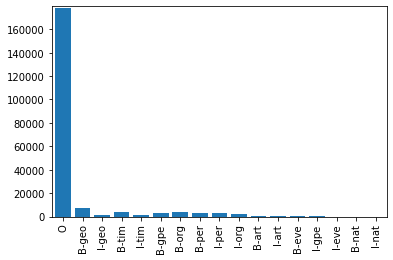

In [19]:
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks  (indexes, labels, rotation="vertical")
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

## Normalizing and vectorizing data